## Feature Engineering
In this section we will: 
- Evaluate a Dummy Classifier
- Evaluate Simple Models
    - For Amount Features
    - For Ratio Features 
- Check Multi-collinearity
- Evaluate Feature Importance
    - Permutation Importance 
    - Feature Selector Performance across different values of n
    - Examine Feature Strength

In [3]:
#import custom modules
from importlib import reload
from helpers.my_imports import *
import helpers.preprocessing as pp
import helpers.plot as plot
import helpers.tools as tools
import helpers.transformers as xfrs
from helpers.reload import myreload

#make sure latest copy of library is loaded
myreload()

#Global Variable for Random State
rs=42 #random_state

#Load dataset
df = pd.read_csv('saved_dfs/preprocessed_negotiations_df.csv')
df.head(2)

Reloaded helpers.preprocessing, helpers.plots, and helpers.tools.


,claim_type,NSA_NNSA,split_claim,negotiation_type,in_response_to,level,facility,carrier,group_number,plan_funding,TPA,TPA_rep,billed_amount,negotiation_amount,offer,counter_offer,decision,service_days,decision_days,offer_days,counter_offer_days,YOB,neg_to_billed,offer_to_neg,offer_to_counter_offer
0,HCFA,NNSA,No,NNSA Negotiation,Insurance Initiated,Level 3,Cedar Hill,Cigna,3344605,FULLY,Zelis,Marissa Pepe,4058.0,4058.0,258.0,3449.0,Rejected,128.0,NaN,0.0,0.0,1984,1.0,0.0636,0.0748
1,UB,NNSA,No,NNSA Negotiation,Insurance Initiated,Level 5,Cedar Hill,Blue Cross Blue Shield,174518M3BH,SELF,Zelis,Courtney Kiernan,52253.0,52253.0,12500.0,44415.0,Rejected,127.0,NaN,2.0,2.0,2021,1.0,0.2392,0.2814


### Define X and y

In [4]:
#Define X and y
X,y=df.drop(columns='decision'), df.decision

#Split and stratify the data
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape

((6398, 24), (2133, 24))

In [5]:
pp.mystats(X, nulls_only=True)

(8531, 24)


,nulls,null_pct,dimensions
decision_days,1883,22.07,44
offer_days,364,4.27,54
counter_offer_days,199,2.33,56
service_days,1,0.01,511


### Dummy Classifier

In [6]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier().fit(X_train, y_train)
dummy_test_preds = dummy_clf.predict(X_test)

In [8]:
print(f"The dummy classifier returns an F1 Weighted score of: {f1_score(y_test, dummy_test_preds, average='weighted'):.3f}")

The dummy classifier returns an F1 Weighted score of: 0.846


### Simple Models

#### Feature Encoding
- OneHotEncode features with less than 10 categories
- Ordinal Encoding for level (levels 2-5)
- We will start with Binary Encoding for features with more than 10 categories.  Later we will also try TargetEncoding and CatBoostEncoding due to the high number of rare values in some of the columns 

In [146]:
#Display number of dimensions for categorical features with more than 3 dimensions to help make encoding decisions
pp.mystats(X[['in_response_to', 'facility', 'carrier', 'TPA', 'TPA_rep', 'group_number']])

(8531, 6)


,nulls,null_pct,dimensions
in_response_to,0,0.0,6
facility,0,0.0,8
carrier,0,0.0,53
TPA,0,0.0,42
TPA_rep,0,0.0,613
group_number,0,0.0,1748


### Define Simple Models

In [147]:
#define models with mainly default settings.  Increased max_iter for logistic function due to a convergence warnings
simple_models = {
    'Logistic Regression': LogisticRegression(max_iter=200, random_state=rs), 
    'Ridge Classifier': RidgeClassifier(random_state=rs),
    'KNN': KNeighborsClassifier(n_jobs=-1),
    'Decision Trees': DecisionTreeClassifier(random_state=rs),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=rs, n_jobs=-1),
    'SVM': SVC(probability=False, random_state=rs), 
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=rs), 
    'Bagging': BaggingClassifier(n_estimators=10, random_state=rs, n_jobs=-1), 
    'Gradient Boost': GradientBoostingClassifier(n_estimators=100, random_state=rs)
}

#### Cross-Validation using Simple Models with default parameters
- The function below: 
    - dynamically builds a copy of the dataset containing just columns passed in as arguments
    - dynamically builds the transformer and pipeline based on arguments passed
    - Returns the mean of the scores from cross_validate() for each model passed in 
- In this first test, we introduce minimal functionality to the pipeline:
    - impute nulls
    - categorical column encoding
    - scaler (We use RobustScaler since we have outliers)
- This test will use the amount columns

In [148]:
simple_fit_models=tools.my_cross_val(df,'decision',['f1_weighted', 'precision_weighted'], 
                   simple_models,
                   
                   num_imputer=('si',SimpleImputer(strategy='most_frequent')),  
                   num_cols=['negotiation_amount', 'billed_amount', 'offer', 'counter_offer', 
                             'counter_offer_days', 'offer_days', 'decision_days', 'service_days', 'YOB'],
                   
                   cat_encoder=('cat_encoder', BinaryEncoder()),
                   cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'], 
                   
                   onehotencoder=('ohe', OneHotEncoder(drop='if_binary')),
                   ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type', 'in_response_to', 'facility', 'plan_funding'],
                   ord_cols=['level'], 

                   scaler= ('scaler', RobustScaler()),
                     
                   set_name='fe_set1', cv=5, verbose=0,
                   test_size=0.25, stratify=True,rs=42)

model,fit_time,score_time,test_f1_weighted,train_f1_weighted,test_precision_weighted,train_precision_weighted
Logistic Regression,0.050497,0.010770,0.926011,0.942718,0.925419,0.942146
Ridge Classifier,0.055378,0.011907,0.902494,0.913012,0.908154,0.919721
KNN,0.029776,0.055252,0.918180,0.942879,0.916772,0.943981
Decision Trees,0.038219,0.011315,0.915011,1.000000,0.915791,1.000000
Random Forest,0.173182,0.027960,0.918706,1.000000,0.921448,1.000000
SVM,0.055883,0.021865,0.928547,0.940706,0.927931,0.941127
AdaBoost,0.303065,0.017816,0.931397,0.970514,0.931486,0.970335
Bagging,0.082669,0.021080,0.931093,0.996382,0.930806,0.996413
Gradient Boost,0.463202,0.010021,0.936391,0.982795,0.935472,0.982892


#### Cross-Validation using Simple Models with default parameters using Ratio columns instead of Amount columns

In [149]:
simple_fit_models_with_ratios=tools.my_cross_val(df,'decision',['f1_weighted', 'precision_weighted'], 
                   simple_models,
                   
                   num_imputer=('si',SimpleImputer(strategy='most_frequent')),  
                   num_cols=['neg_to_billed', 'offer_to_neg', 'offer_to_counter_offer',  
                             'counter_offer_days', 'offer_days', 'decision_days', 'service_days', 'YOB'],
                   
                   cat_encoder=('cat_encoder', BinaryEncoder()),
                   cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'], 
                   
                   onehotencoder=('ohe', OneHotEncoder(drop='if_binary')),
                   ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type', 'in_response_to', 'facility', 'plan_funding'],
                   ord_cols=['level'], 

                   scaler= ('scaler', RobustScaler()),
                     
                   set_name='fe_set2', cv=5, verbose=0,
                   test_size=0.25, stratify=True,rs=42)

model,fit_time,score_time,test_f1_weighted,train_f1_weighted,test_precision_weighted,train_precision_weighted
Logistic Regression,0.085582,0.020758,0.941718,0.951170,0.941227,0.950594
Ridge Classifier,0.052655,0.014231,0.935189,0.941268,0.934369,0.940481
KNN,0.031532,0.021578,0.925227,0.948785,0.924840,0.948669
Decision Trees,0.034696,0.009566,0.917549,1.000000,0.918261,1.000000
Random Forest,0.166246,0.033594,0.938784,1.000000,0.938098,1.000000
SVM,0.066325,0.020909,0.937420,0.945885,0.937126,0.945128
AdaBoost,0.283368,0.015386,0.933621,0.972310,0.934619,0.972288
Bagging,0.071868,0.018413,0.930807,0.997430,0.933911,0.997455
Gradient Boost,0.385460,0.009396,0.936532,0.987550,0.936237,0.987575


There is a considerable improvement using ratios for almost all the models.  As a result we will drop the amount features and use the ratios going forward 

### Redefine X and y

In [150]:
#Define X and y so we can check multicollinearity and evaluate permutation importance
X,y=df.drop(columns=['decision', 'billed_amount', 'negotiation_amount', 'offer', 'counter_offer']), df.decision

#Split and stratify the data
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape

((6398, 20), (2133, 20))

### Check Multicolinearity 
Calculate VIF after using SimpleImputer with strategy= most_frequent

In [151]:
tools.vif(X, impute_strategy='most_frequent').sort_values(by='VIF', ascending = False)

,VIF
offer_to_neg,8.631281
offer_to_counter_offer,8.418126
offer_days,3.296877
counter_offer_days,3.232707
decision_days,1.636780
service_days,1.047615
neg_to_billed,1.016720
YOB,1.001126


offer_to_neg and offer_counter_offer is high but under 10 which is still acceptable especially considering that the models seem to perform better using ratio

### Evaluate Permutation Importance
This technique involves randomly shuffling individual features and measuring the change in the model's performance. Features that cause a significant drop in performance when permuted are deemed important because the model relies on them for making accurate predictions. We look at these results for Logistic Regression, KNN and SVM

In [152]:
tools.my_permutation_importance(simple_fit_models_with_ratios, X_test, y_test, scoring='f1_weighted', 
                                n_repeats=30, rs=42)

Logistic Regression:


Variables,offer_to_neg,offer_to_counter_offer,negotiation_type,TPA,plan_funding,claim_type,TPA_rep,decision_days,in_response_to,offer_days,level,facility,carrier,split_claim,service_days,NSA_NNSA,YOB,neg_to_billed,counter_offer_days,group_number
Score,0.070487,0.036767,0.008393,0.006715,0.003296,0.002834,0.002596,0.002027,0.001794,0.00159,0.000948,0.000705,0.000002,-0.000067,-0.000074,-0.000181,-0.000305,-0.00034,-0.000433,-0.001383


Ridge Classifier:


Variables,offer_to_neg,negotiation_type,offer_to_counter_offer,TPA,in_response_to,plan_funding,service_days,carrier,claim_type,YOB,group_number,TPA_rep,offer_days,level,facility,counter_offer_days,neg_to_billed,split_claim,decision_days,NSA_NNSA
Score,0.094141,0.009945,0.00612,0.004032,0.001793,0.001727,0.001181,0.000935,0.000882,0.00073,0.000725,0.000523,0.000522,0.000407,0.000387,0.000297,0.000195,0.000026,-0.000084,-0.001296


KNN:


Variables,offer_to_neg,offer_to_counter_offer,decision_days,neg_to_billed,group_number,TPA_rep,plan_funding,TPA,offer_days,level,YOB,service_days,carrier,counter_offer_days,claim_type,split_claim,in_response_to,facility,NSA_NNSA,negotiation_type
Score,0.061173,0.016134,0.004561,0.004319,0.004185,0.003317,0.002789,0.001854,0.001644,0.000613,0.000419,0.000384,0.000268,0.000171,0.000058,0.0,-0.000611,-0.000735,-0.000976,-0.002653


Decision Trees:


Variables,offer_to_neg,offer_to_counter_offer,plan_funding,offer_days,TPA_rep,negotiation_type,facility,level,in_response_to,counter_offer_days,YOB,decision_days,TPA,carrier,group_number,claim_type,service_days,split_claim,neg_to_billed,NSA_NNSA
Score,0.116622,0.019808,0.009395,0.005442,0.004986,0.003952,0.003635,0.002925,0.002329,0.002272,0.002251,0.002236,0.002142,0.002132,0.001307,0.001245,0.00111,0.000559,-0.00009,-0.000106


Random Forest:


Variables,offer_to_neg,offer_to_counter_offer,TPA,plan_funding,neg_to_billed,negotiation_type,group_number,carrier,level,counter_offer_days,facility,claim_type,in_response_to,offer_days,YOB,service_days,split_claim,NSA_NNSA,TPA_rep,decision_days
Score,0.074096,0.038073,0.005034,0.003299,0.002835,0.002597,0.00244,0.002398,0.00128,0.001222,0.001141,0.001019,0.00083,0.000198,0.000029,-0.00018,-0.000381,-0.000594,-0.000746,-0.001064


SVM:


Variables,offer_to_neg,offer_to_counter_offer,negotiation_type,offer_days,decision_days,counter_offer_days,TPA,plan_funding,in_response_to,neg_to_billed,NSA_NNSA,group_number,carrier,split_claim,YOB,claim_type,TPA_rep,level,facility,service_days
Score,0.086759,0.012999,0.002329,0.002151,0.001826,0.001201,0.001071,0.000904,0.000824,0.000531,0.000343,-0.000027,-0.000133,-0.000186,-0.000228,-0.000638,-0.000999,-0.001221,-0.002024,-0.002337


AdaBoost:


Variables,offer_to_neg,offer_to_counter_offer,negotiation_type,offer_days,plan_funding,TPA,group_number,decision_days,neg_to_billed,claim_type,in_response_to,NSA_NNSA,counter_offer_days,split_claim,level,facility,YOB,TPA_rep,service_days,carrier
Score,0.068475,0.051607,0.011129,0.004406,0.003635,0.002973,0.002317,0.001259,0.001108,0.000509,0.000423,0.0,0.0,-0.000535,-0.000536,-0.000573,-0.001124,-0.002128,-0.002281,-0.002654


Bagging:


Variables,offer_to_neg,offer_to_counter_offer,plan_funding,negotiation_type,decision_days,counter_offer_days,neg_to_billed,TPA_rep,level,carrier,offer_days,split_claim,NSA_NNSA,in_response_to,TPA,claim_type,facility,service_days,group_number,YOB
Score,0.117066,0.010466,0.005902,0.004585,0.001325,0.000936,0.000897,0.000758,0.000593,0.000552,0.000189,-0.000041,-0.000041,-0.000053,-0.000168,-0.000196,-0.00045,-0.000464,-0.000792,-0.003027


Gradient Boost:


Variables,offer_to_neg,offer_to_counter_offer,level,decision_days,facility,plan_funding,carrier,NSA_NNSA,counter_offer_days,YOB,in_response_to,split_claim,offer_days,TPA_rep,negotiation_type,neg_to_billed,group_number,TPA,service_days,claim_type
Score,0.080472,0.043943,0.001758,0.001553,0.000993,0.000853,0.000537,0.000491,0.000402,0.000233,0.000145,0.0,-0.000005,-0.000066,-0.000339,-0.000353,-0.000357,-0.000603,-0.000872,-0.00149


The results show that the most important features overall across all models are offer_to_neg and offer_to_counter_offer.  The other results are mostly model dependent. 

### Evaluate effects of a Feature Selector for varying values of max_features
To try to get a better idea of the important features and the number of important features, we evaluate our models against varying values of `max_features` to be selected in a `SelectFromModel`/`LogisticRegression` selector. 

#### Define New Baseline CV Transformer
For this test we define a new cross-validation  transformer which incorporates the observations from EDA and   includes steps we are plan to use in Cross-Validation.  We include: 
- `yeo_johnson PowerTransformer` which will be applied to numeric features related to amounts and number of days (as discussed in EDA)
- `RareCategoryCombiner2` which will combine rare categories below a threshold to a value of `Unknown` 

In [43]:
#Assign column categories
ohe_cols = ['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type', 'in_response_to', 
            'facility', 'plan_funding']
cat_cols = ['carrier', 'TPA', 'group_number','TPA_rep']
ord_cols = ['level']
num_cols = ['neg_to_billed', 'offer_to_neg', 'offer_to_counter_offer',
            'service_days', 'offer_days', 'counter_offer_days', 'decision_days', 'YOB']

#Transformer includes yeo-johnson Power Transformer 
#Transformer also includes a class to combine rare categories
baseline_cv_transformer = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            #('log', #xfrs.LogTransformer(add_constant=1)),  # Applying log transform
            ('yeo', PowerTransformer(method='yeo-johnson')), 
            ('poly', PolynomialFeatures())
        ]), num_cols),
        ('cat', Pipeline([
            ('combiner', xfrs.RareCategoryCombiner2(threshold=20)),
            ('cat_encoder', BinaryEncoder())
        ]), cat_cols),
        ('ohe', OneHotEncoder(), ohe_cols),
        ('ord', OrdinalEncoder(), ord_cols)
    ],
    remainder='passthrough'
)
baseline_cv_transformer.fit(X_train, y_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('yeo', PowerTransformer()),
                                                 ('poly',
                                                  PolynomialFeatures())]),
                                 ['neg_to_billed', 'offer_to_neg',
                                  'offer_to_counter_offer', 'service_days',
                                  'offer_days', 'counter_offer_days',
                                  'decision_days', 'YOB']),
                                ('cat',
                                 Pipeline(steps=[('combiner',
                                                  RareCategoryCombiner2(threshold=20)),
                                                 ('cat_encoder',
                                                  BinaryEncoder())]),
                                 ['carrier', 'TPA', 'group_number', 'TPA_rep']),
                                ('ohe', OneHotEncoder(),
                                 ['claim_type', 'NSA_NNSA', 'split_claim',
                                  'negotiation_type', 'in_response_to',
                                  'facility', 'plan_funding']),
                                ('ord', OrdinalEncoder(), ['level'])])

In [44]:
#Get Total Number of Features
total_num_features = baseline_cv_transformer.output_indices_['ord'].stop
total_num_features

91

For this test we will exclude `DecisionTreeClassifier` and `RidgeClassifier` since we have similar models in our set. 
#### Calculate cross-validation scores for each model and value of max_features

In [83]:
#Define list of models 
simple_models = {
    'lgr': LogisticRegression(max_iter=1000, random_state=rs, n_jobs=1), 
    'knn': KNeighborsClassifier(n_jobs=-1),
    'rf': RandomForestClassifier(n_estimators=100, random_state=rs, n_jobs=-1),
    'svm': SVC(probability=False, random_state=rs), 
    'ada': AdaBoostClassifier(n_estimators=100, random_state=rs), 
    'bag': BaggingClassifier(n_estimators=10, random_state=rs, n_jobs=-1), 
    'gbc': GradientBoostingClassifier(n_estimators=100, random_state=rs)
}

#Cross-Validation for each model across values of n greater or equal to 5
sfm_scores=pd.DataFrame()
for model_name, model in simple_models.items(): 
    n_indices, scores=[], []
    print(f"Calculating scores for: {model_name}")
    for n in np.arange(5,87,1):  
 
        # Full pipeline with oversampling, undersampling, scaling, and logistic regression
        sfm_cv_pipe = ImbPipeline([
            ('transformer', baseline_cv_transformer),
            ('over', SMOTE(random_state=42)),
            ('under', RandomUnderSampler(random_state=42)),
            ('scaler', RobustScaler()),
            ('selector', SelectFromModel(max_features=n, 
                             estimator=LogisticRegression(penalty='l1', C=1, solver='liblinear', 
                                                          max_iter=5_000, random_state=rs, n_jobs=1))),
            ('clf', model)
        ])

        #Fit Pipe
        sfm_cv_pipe.fit(X_train, y_train)

        #Calculate CV Score
        scores.append(cross_val_score(sfm_cv_pipe, X_test, y_test, scoring='f1_weighted', cv=5).mean())
        n_indices.append(n)
    sfm_scores[model_name]=scores
    sfm_scores.index=n_indices
    
#save sfm_scores
sfm_scores.to_csv('saved_dfs/sfm_scores.csv', index=False)

Calculating scores for: lgr
Calculating scores for: knn
Calculating scores for: rf
Calculating scores for: svm
Calculating scores for: ada
Calculating scores for: bag
Calculating scores for: gbc


#### Visualize cross-validation scores for different models and values of max_features

In [ ]:
#To retrieve sfm_scores without re-running the code above, uncomment the code
#sfm_scores = pd.read_csv('saved_dfs/sfm_scores.csv')

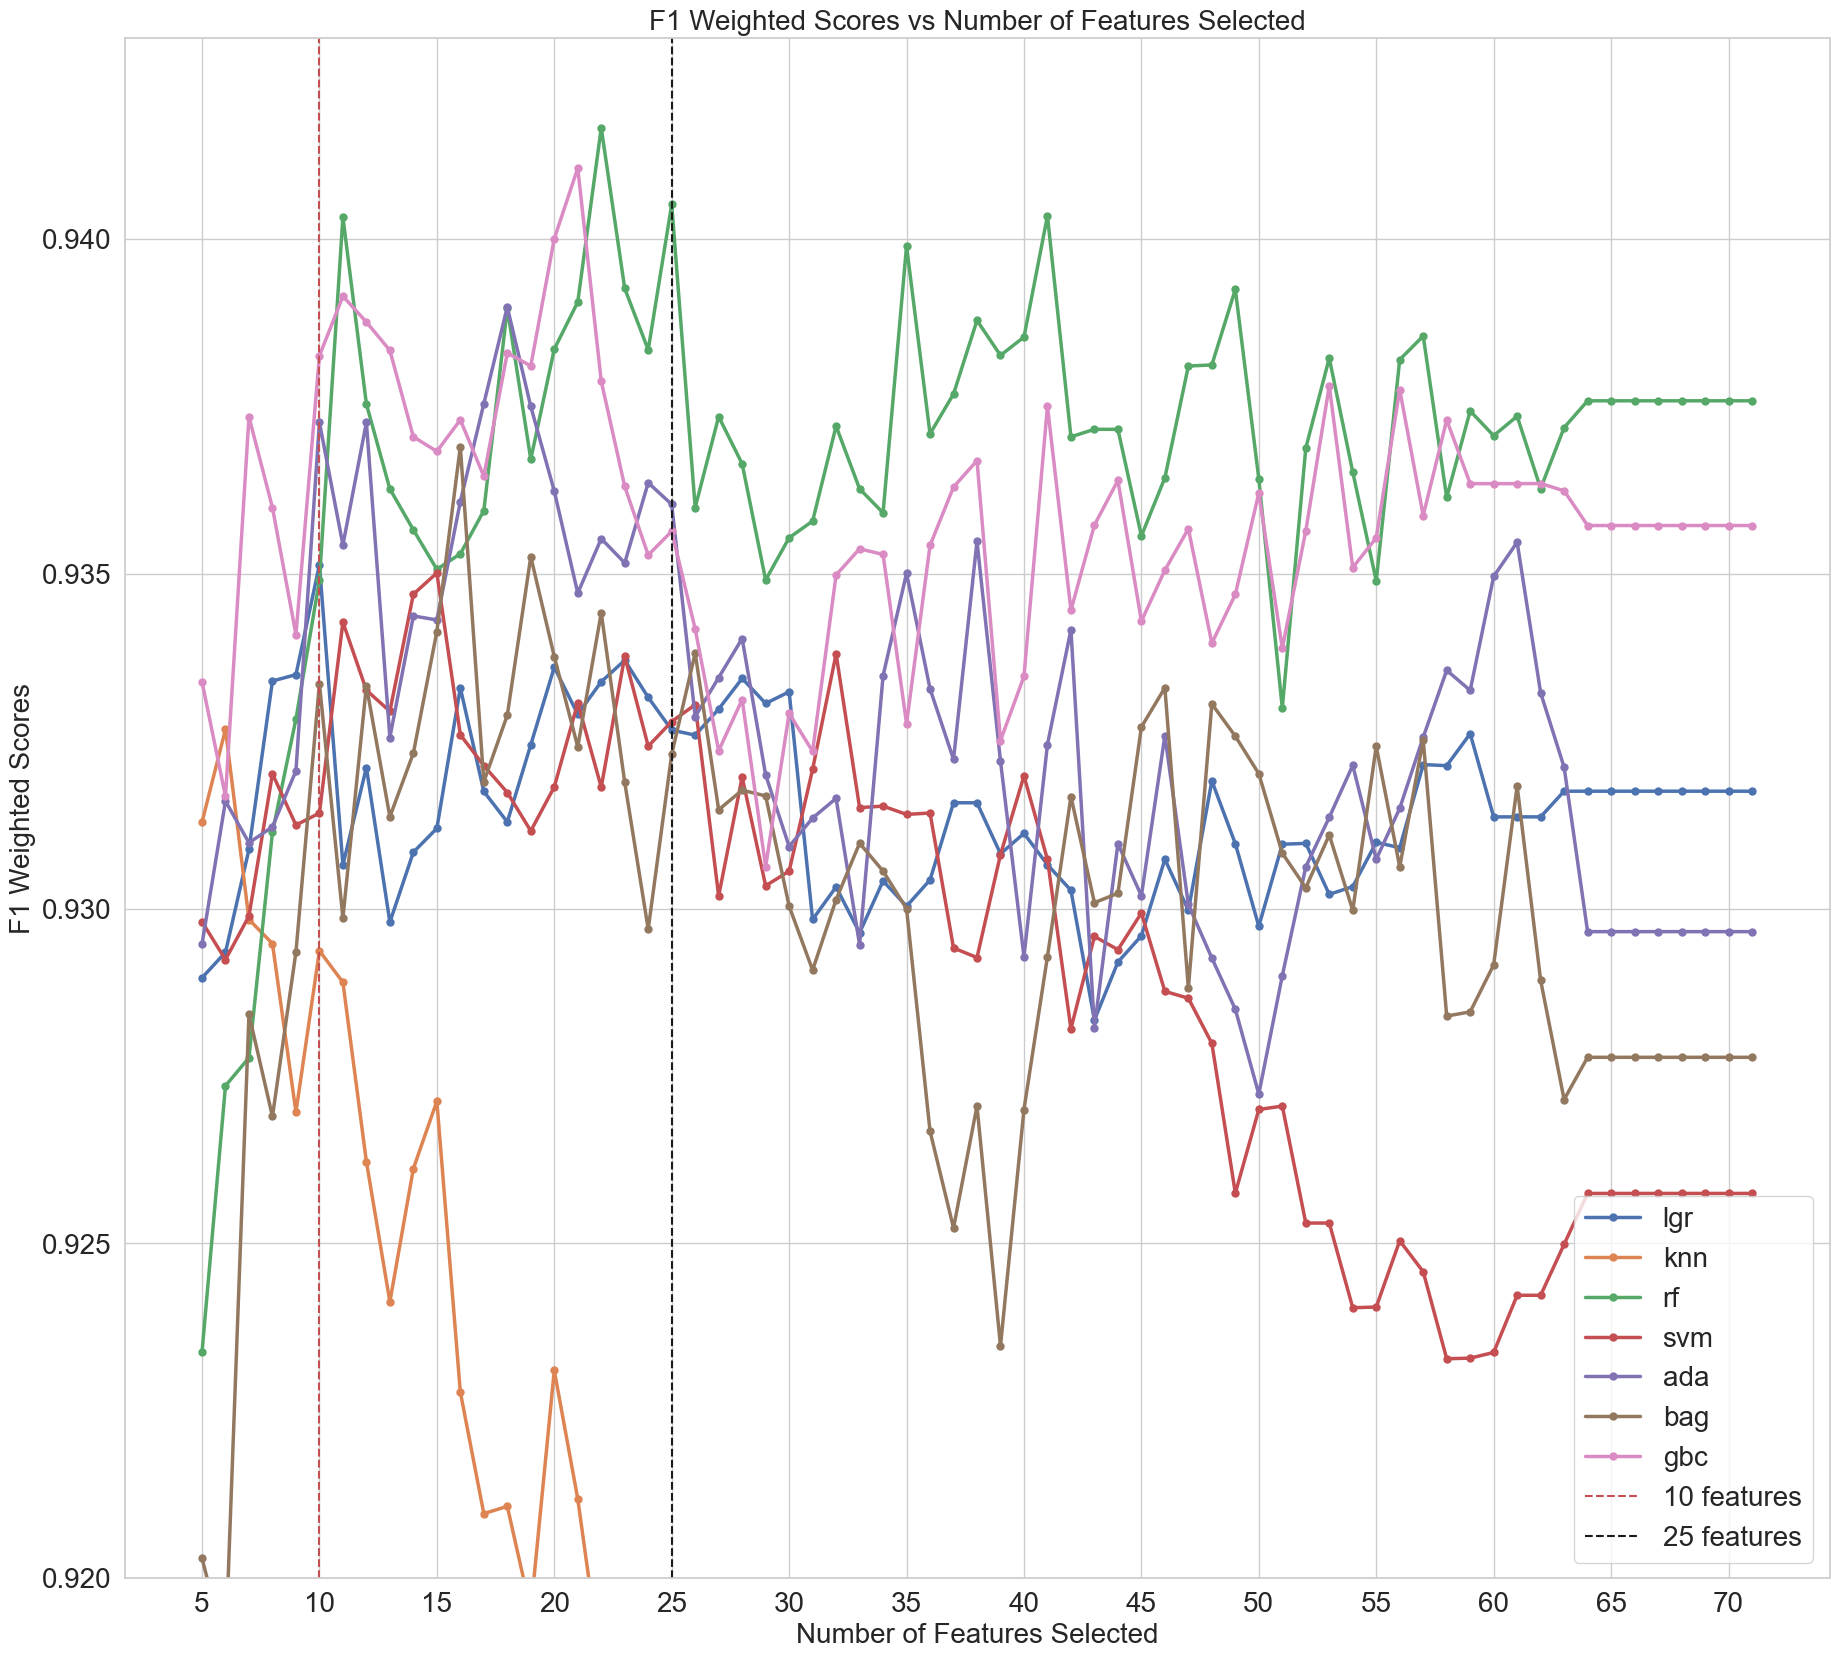

In [95]:
lower_bound=10
upper_bound=25

# Set figure size, style and common font size for labels and ticks
plt.figure(figsize=(22, 20))
sns.set(style="whitegrid", font_scale=1)
common_fontsize = 20

#Plot classifier scores vs n_features_to_select 
"""plt.plot(sfm_scores.index, sfm_scores['lgr'], label='lgr', marker='o', linewidth=2.5, markersize=5)
plt.plot(sfm_scores.index, sfm_scores['knn'], label='knn', marker='o', linewidth=2.5, markersize=5)
plt.plot(sfm_scores.index, sfm_scores['rf'], label='rf', marker='o', linewidth=2.5, markersize=5)
plt.plot(sfm_scores.index, sfm_scores['svm'], label='svm', marker='o', linewidth=2.5, markersize=5)
plt.plot(sfm_scores.index, sfm_scores['ada'], label='ada', marker='o', linewidth=2.5, markersize=5)
plt.plot(sfm_scores.index, sfm_scores['bag'], label='bag', marker='o', linewidth=2.5, markersize=5)
plt.plot(sfm_scores.index, sfm_scores['gbc'], label='gbc', marker='o', linewidth=2.5, markersize=5)"""
for column in sfm_scores.columns:
    plt.plot(sfm_scores.index[sfm_scores.index <= 71], sfm_scores[column][sfm_scores.index <= 71], label=column, marker='o', linewidth=2.5, markersize=5)

plt.axvline(x=lower_bound, color='r', linestyle='--', label=f'{lower_bound} features')
plt.axvline(x=upper_bound, color='k', linestyle='--', label=f'{upper_bound} features')
plt.title('F1 Weighted Scores vs Number of Features Selected', fontsize=common_fontsize)
plt.ylabel('F1 Weighted Scores',fontsize=common_fontsize)
plt.xlabel('Number of Features Selected',fontsize=common_fontsize)
plt.xticks(np.arange(5, 75, 5),fontsize=common_fontsize)
plt.yticks(fontsize=common_fontsize)
plt.ylim(0.92, 0.943)
plt.legend(loc=(0.85, 0.01), fontsize=common_fontsize)

plt.show()

#### Observations related to  Feature Selection for different values of n: 
- It looks like for most models n=10 to n=25 is the most interesting range, although RandomForest and GradientBoostClassifier continue to do well up until ~n=41

Below we take a look at the features that were excluded vs the features that remained at n=26

#### View excluded features for n=26

In [136]:
cv_baseline_pipe = ImbPipeline([
            ('transformer', baseline_cv_transformer),
            ('over', SMOTE(random_state=42)),
            ('under', RandomUnderSampler(random_state=42)),
            ('scaler', RobustScaler()),
            ('selector', SelectFromModel(max_features=42, 
                             estimator=LogisticRegression(penalty='l1', C=1, solver='liblinear', 
                                                          max_iter=5_000, random_state=rs, n_jobs=1))),
            #('clf', LogisticRegression(max_iter=1000, random_state=rs, n_jobs=1))
        ])

cv_baseline_pipe.fit(X_train, y_train)
selected_features, discarded_features = tools.custom_get_feature_names(cv_baseline_pipe)
selected_features

array(['offer_to_neg', 'offer_to_counter_offer', 'service_days',
       'offer_days', 'counter_offer_days', 'decision_days', 'YOB',
       'neg_to_billed^2', 'neg_to_billed offer_to_neg',
       'neg_to_billed offer_to_counter_offer', 'neg_to_billed offer_days',
       'neg_to_billed counter_offer_days', 'offer_to_neg^2',
       'offer_to_neg service_days', 'offer_to_neg decision_days',
       'offer_to_neg YOB', 'offer_to_counter_offer^2',
       'offer_to_counter_offer counter_offer_days', 'offer_days^2',
       'offer_days counter_offer_days', 'carrier_0', 'carrier_2', 'TPA_0',
       'TPA_2', 'group_number_0', 'group_number_1', 'group_number_2',
       'group_number_4', 'group_number_5', 'TPA_rep_2', 'TPA_rep_5',
       'claim_type_HCFA', 'NSA_NNSA_NNSA', 'NSA_NNSA_NSA',
       'split_claim_No', 'split_claim_Yes',
       'negotiation_type_NNSA Negotiation',
       'negotiation_type_Open Negotiation',
       'in_response_to_Corrected Claim',
       'in_response_to_Reconsideration Le

#### Retest without level and plan_funding
Since `level` and `plan_funding` are not part of the first 41 features selected, we redo our cross-validation without them

In [153]:
myreload()
fe_set3_models=tools.my_cross_val(df,'decision',['f1_weighted', 'precision_weighted'], 
                   simple_models,
                   
                   num_imputer=('si',SimpleImputer(strategy='most_frequent')),  
                   num_cols=['neg_to_billed', 'offer_to_neg', 'offer_to_counter_offer',  
                             'counter_offer_days', 'offer_days', 'decision_days', 'service_days', 'YOB'],
                   
                   cat_encoder=('cat_encoder', BinaryEncoder()),
                   cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'], 
                   
                   onehotencoder=('ohe', OneHotEncoder(drop='if_binary')),
                   ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type', 'in_response_to', 'facility'],
                   ord_cols=[], 

                   scaler= ('scaler', RobustScaler()),
                     
                   set_name='fe_set3', cv=5, verbose=0,
                   test_size=0.25, stratify=True,rs=42)

Reloaded helpers.preprocessing, helpers.plots, and helpers.tools.


model,fit_time,score_time,test_f1_weighted,train_f1_weighted,test_precision_weighted,train_precision_weighted
Logistic Regression,0.090189,0.025252,0.941719,0.950890,0.940940,0.950294
Ridge Classifier,0.054152,0.010916,0.935850,0.940719,0.935220,0.939870
KNN,0.047075,0.036805,0.922787,0.944421,0.921197,0.944067
Decision Trees,0.033077,0.009113,0.913690,1.000000,0.915770,1.000000
Random Forest,0.166090,0.033578,0.939534,1.000000,0.939191,1.000000
SVM,0.053311,0.020444,0.936897,0.945123,0.936374,0.944347
AdaBoost,0.279880,0.016379,0.933058,0.972556,0.933945,0.972552
Bagging,0.065352,0.017261,0.933251,0.997430,0.935904,0.997454
Gradient Boost,0.371999,0.009305,0.939413,0.986680,0.939339,0.986742


Indeed, the scores are mostly similar and even slightly better so when we do more in-depth Cross-Validation and Hyperparameter tuning, we can compare performance with and without these fields. 

#### Feature Regularization
We take one more look at feature importance through the residual feature strength after regulariation. We will only look at a few low dimension features because otherwise the plot would get too crowded to be interpretable 

In [154]:
ohe_cols_FR = ['NSA_NNSA', 'split_claim', 'claim_type'] 
binary_cols_FR = [] 
ordinal_cols_FR = []
numerical_cols_FR =['neg_to_billed', 'offer_to_neg', 'offer_to_counter_offer', 
                    'service_days', 'offer_days', 'counter_offer_days']

In [155]:
X_FR=X[ohe_cols_FR+binary_cols_FR+ordinal_cols_FR+numerical_cols_FR]

In [156]:
#Define FR Transformer
transformer_FR = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('log', xfrs.LogTransformer(add_constant=1)),  # Applying log transform
            #('poly', PolynomialFeatures())
        ]), numerical_cols_FR),
        ('ohe', OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='ignore'), ohe_cols_FR),
        ('binary', BinaryEncoder(), binary_cols_FR),
        ('ordinal', OrdinalEncoder(), ordinal_cols_FR)
    ], remainder='passthrough')

In [157]:
pipe_FR = ImbPipeline([
            ('transformer', transformer_FR),
            #('over', SMOTE(random_state=42)),
            #('under', RandomUnderSampler(random_state=42)),
            ('scaler', RobustScaler()) ])

In [158]:
X_FR_transformed = pipe_FR.fit_transform(X_FR, y)

In [159]:
X_FR_transformed.shape, y.shape

((8531, 9), (8531,))

In [160]:
transf = pipe_FR.named_steps['transformer']
ohe_feature_names = list(transf.named_transformers_['ohe'].get_feature_names_out())

In [161]:
#Set value of Cs so that we have a wide range of C values on the lower end of the scale where regularization is strongest
Cs = np.logspace(-5, .5) 
coef_list = []

for C in Cs:
    #libinear is for small datasets and ovr and supports l1 and l2
    logreg = LogisticRegression(penalty='l1', solver ='liblinear', C=C, random_state=42, max_iter=1000)
    logreg.fit(X_FR_transformed,y)
    coef_list.append(list(logreg.coef_[0]))

coef_df = pd.DataFrame(coef_list, columns = ohe_feature_names+numerical_cols_FR)
coef_df.index = Cs
coef_df.head(2)

,NSA_NNSA_NSA,split_claim_Yes,claim_type_UB,neg_to_billed,offer_to_neg,offer_to_counter_offer,service_days,offer_days,counter_offer_days
0.000010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.000013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(1, 0.0001)

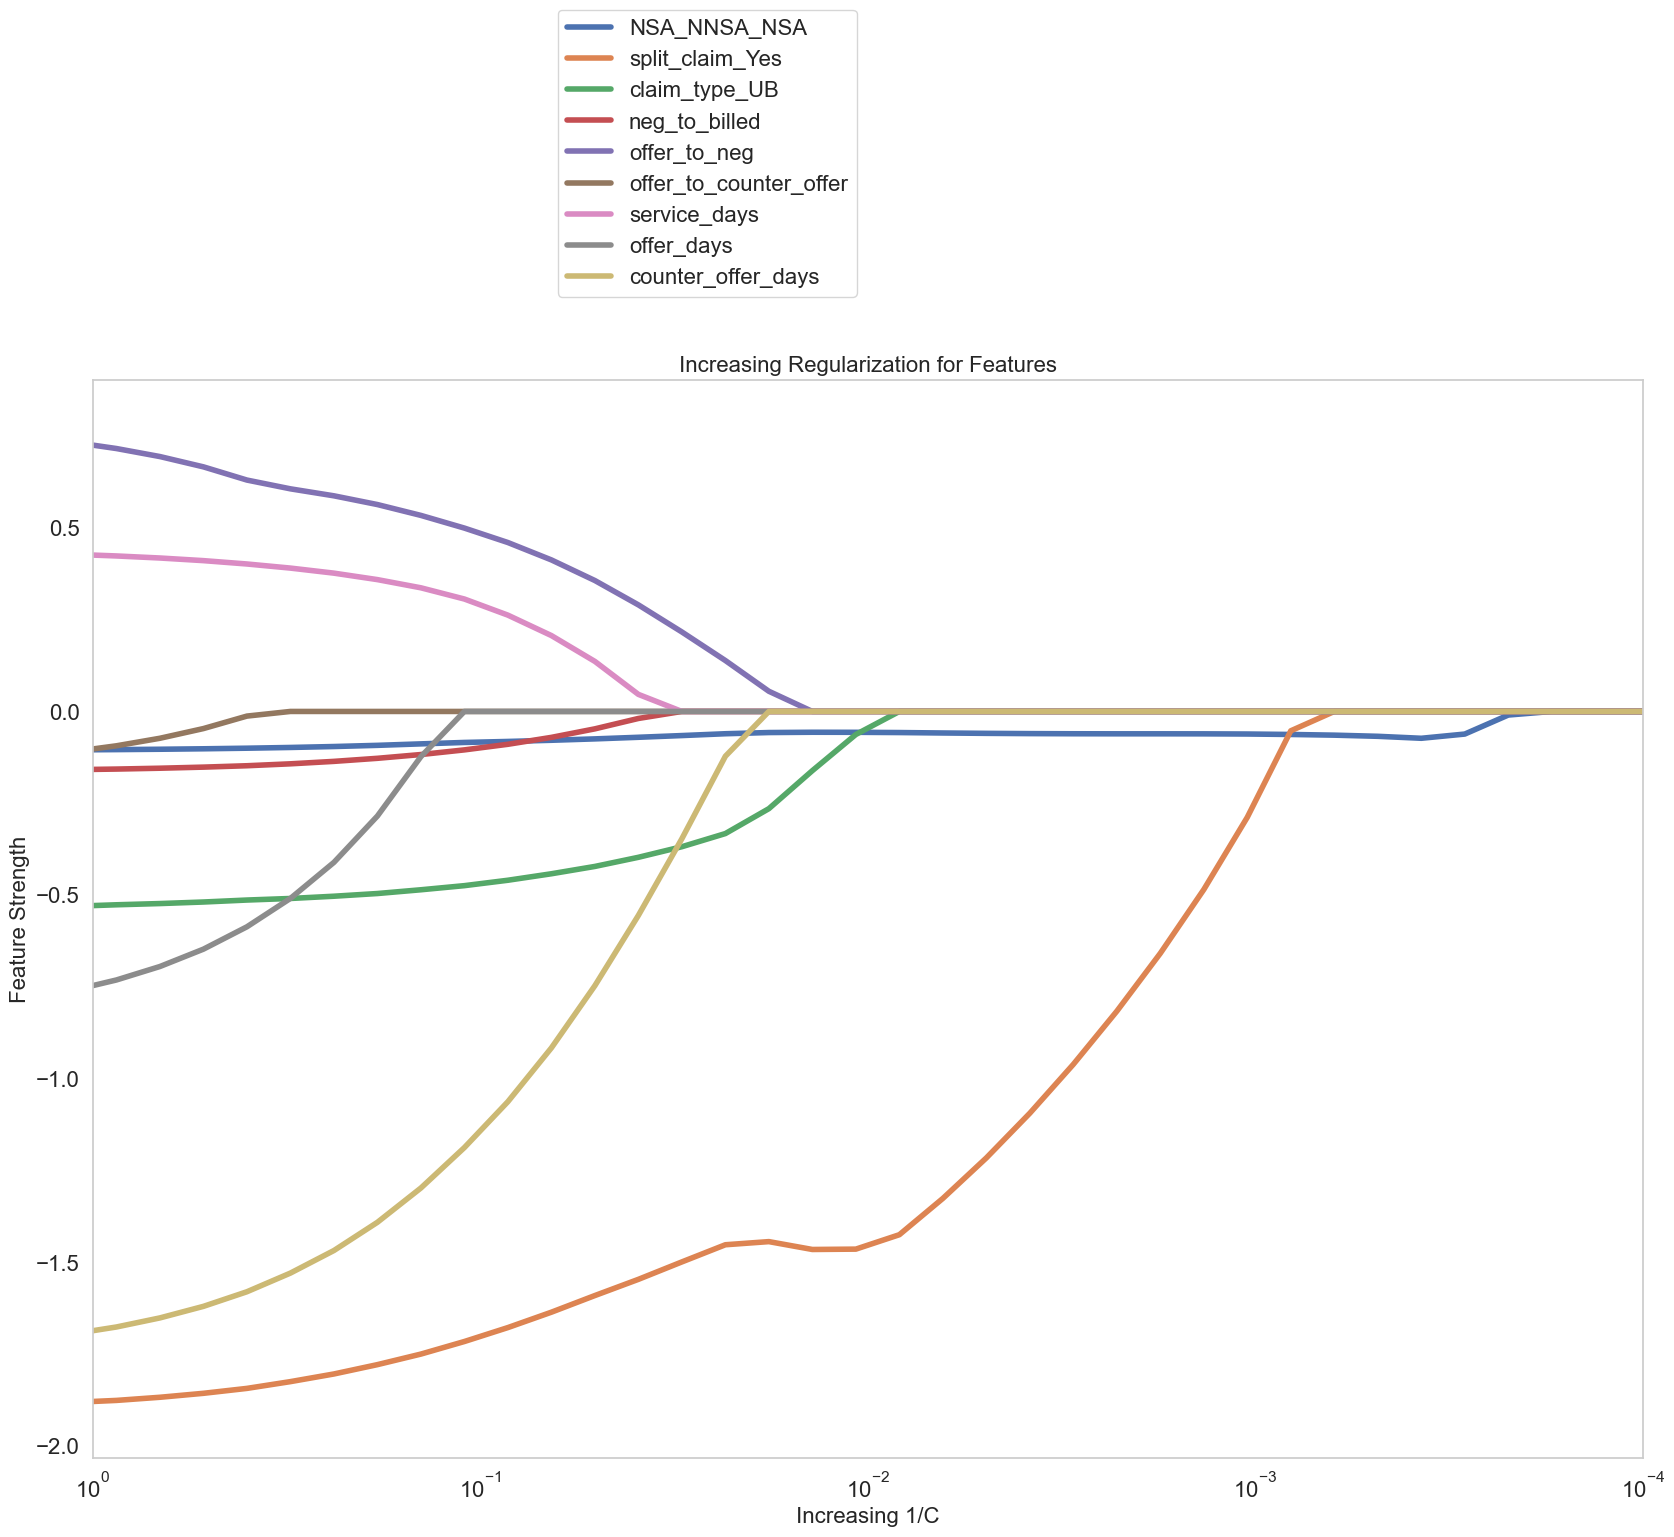

In [162]:
#Visualize feature strength with increasing regularatization
common_fontsize=16
plt.figure(figsize = (20, 14))
plt.semilogx(coef_df, linewidth=4)
plt.gca().invert_xaxis()
plt.grid()
plt.legend(list(coef_df.columns), loc='center right', bbox_to_anchor=(0.5,1.21), fontsize=common_fontsize)
plt.title('Increasing Regularization for Features', fontsize=common_fontsize)
plt.xlabel("Increasing 1/C", fontsize=common_fontsize)
plt.ylabel("Feature Strength", fontsize=common_fontsize)
plt.xticks(fontsize=common_fontsize)
plt.yticks(fontsize=common_fontsize)
plt.xlim(1,0.0001)

1/C tends to become relatively stable around 0.1 which means C = 10

#### Retest without neg_to_billed and offer_to_counter_offer

In [163]:
myreload()
fe_set4_models=tools.my_cross_val(df,'decision',['f1_weighted', 'precision_weighted'], 
                   simple_models,
                   
                   num_imputer=('si',SimpleImputer(strategy='most_frequent')),  
                   num_cols=[ 'offer_to_neg', 
                             'counter_offer_days', 'offer_days', 'service_days', 'YOB'],
                   
                   cat_encoder=('cat_encoder', BinaryEncoder()),
                   cat_cols=['carrier', 'TPA', 'group_number'], 
                   
                   onehotencoder=('ohe', OneHotEncoder(drop='if_binary')),
                   ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type', 'in_response_to', 'facility', 'plan_funding'],
                   ord_cols=[], 

                   scaler= ('scaler', RobustScaler()),
                     
                   set_name='fe_set4', cv=5, verbose=0,
                   test_size=0.25, stratify=True,rs=42)

Reloaded helpers.preprocessing, helpers.plots, and helpers.tools.


model,fit_time,score_time,test_f1_weighted,train_f1_weighted,test_precision_weighted,train_precision_weighted
Logistic Regression,0.092192,0.015508,0.941363,0.948101,0.940616,0.947439
Ridge Classifier,0.046290,0.014678,0.935438,0.940274,0.934939,0.939479
KNN,0.031018,0.019609,0.923101,0.952214,0.921638,0.951837
Decision Trees,0.026792,0.007966,0.922013,1.000000,0.923194,1.000000
Random Forest,0.144438,0.031686,0.937255,1.000000,0.936848,1.000000
SVM,0.041863,0.017232,0.940352,0.954025,0.939637,0.953532
AdaBoost,0.238509,0.014500,0.935142,0.968031,0.935660,0.967967
Bagging,0.055984,0.014523,0.930197,0.996504,0.934666,0.996563
Gradient Boost,0.279748,0.008383,0.935074,0.981309,0.934953,0.981331


It appears neg_to_billed and offer_to_counter_offer have some limited importance 

In [164]:
myreload()
fe_set5_models=tools.my_cross_val(df,'decision',['f1_weighted', 'precision_weighted'], 
                   simple_models,
                   
                   num_imputer=('si',SimpleImputer(strategy='most_frequent')),  
                   num_cols=[ 'offer_to_neg', 'neg_to_billed', 'offer_to_counter_offer',
                             'counter_offer_days', 'offer_days', 'service_days', 'YOB'],
                   
                   cat_encoder=('cat_encoder', BinaryEncoder()),
                   cat_cols=['carrier', 'TPA', 'group_number'], 
                   
                   onehotencoder=('ohe', OneHotEncoder(drop='if_binary')),
                   ohe_cols=['claim_type', 'split_claim', 'negotiation_type', 'in_response_to', 'facility', 'plan_funding'],
                   ord_cols=[], 

                   scaler= ('scaler', RobustScaler()),
                     
                   set_name='fe_set5', cv=5, verbose=0,
                   test_size=0.25, stratify=True,rs=42)

Reloaded helpers.preprocessing, helpers.plots, and helpers.tools.


model,fit_time,score_time,test_f1_weighted,train_f1_weighted,test_precision_weighted,train_precision_weighted
Logistic Regression,0.083809,0.018074,0.941473,0.949270,0.940687,0.948631
Ridge Classifier,0.036515,0.010918,0.934998,0.940414,0.934342,0.939626
KNN,0.030718,0.014661,0.931227,0.952157,0.930129,0.951689
Decision Trees,0.029341,0.007284,0.923472,1.000000,0.925393,1.000000
Random Forest,0.149438,0.031076,0.943213,1.000000,0.942814,1.000000
SVM,0.044809,0.020450,0.942212,0.951760,0.941680,0.951170
AdaBoost,0.256089,0.015018,0.936442,0.970434,0.936893,0.970422
Bagging,0.057866,0.016608,0.932296,0.996498,0.935599,0.996539
Gradient Boost,0.333266,0.007971,0.934291,0.986700,0.934480,0.986766


NSA_NNSA also has some limited importance

### Summary of Findings
- Dummy Classifier score: 0.84
- We will be replacing the amount fields billed_amount, negotiation_amount, offer, counter_offer, with 3 ratio columns as we saw that this reduces multicollinearity and improves the performance across most model types
- Permutation Importance showed that offer_to_neg and offer_to_counter_offer are the most important features across most models
- Using simple models without fully built transformers, and without hyper parameter tuning we see slightly overfit models with F1 weighted scores ranging from ~0.93 to ~0.94
- Our Cross-Validation against different values of n features showed that RandomForest and GradientBoosting looked the most promising, especially between n=10 to n=25 features, but continued to do well up until ~n=41
- Regularization stabilizes around 1/C=0.1 (i.e. C=10)